In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import os
import IPython.display as ipd

import scipy.io.wavfile as wav
import wave
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd
import scipy.io.wavfile as wav
import pylab
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, Model, load_model

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/audio.zip

Archive:  /content/drive/MyDrive/audio.zip
  inflating: free-spoken-digit-dataset-master/.gitignore  
  inflating: free-spoken-digit-dataset-master/README.md  
  inflating: free-spoken-digit-dataset-master/__init__.py  
  inflating: free-spoken-digit-dataset-master/acquire_data/say_numbers_prompt.py  
  inflating: free-spoken-digit-dataset-master/acquire_data/split_and_label_numbers.py  
  inflating: free-spoken-digit-dataset-master/metadata.py  
  inflating: free-spoken-digit-dataset-master/pip_requirements.txt  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_0.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_1.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_10.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_11.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_12.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_13.wav  
  inflating: free-spoken-digit-d

In [6]:
os.mkdir("direct")

In [7]:
input_dir = '/content/free-spoken-digit-dataset-master/recordings'
output_dir = 'direct'

In [8]:
parent_list = os.listdir(input_dir)
for i in range(10):
    print(parent_list[i])

8_lucas_19.wav
1_jackson_1.wav
1_nicolas_35.wav
7_lucas_9.wav
9_yweweler_31.wav
3_yweweler_38.wav
8_nicolas_20.wav
6_yweweler_24.wav
1_jackson_0.wav
4_jackson_39.wav


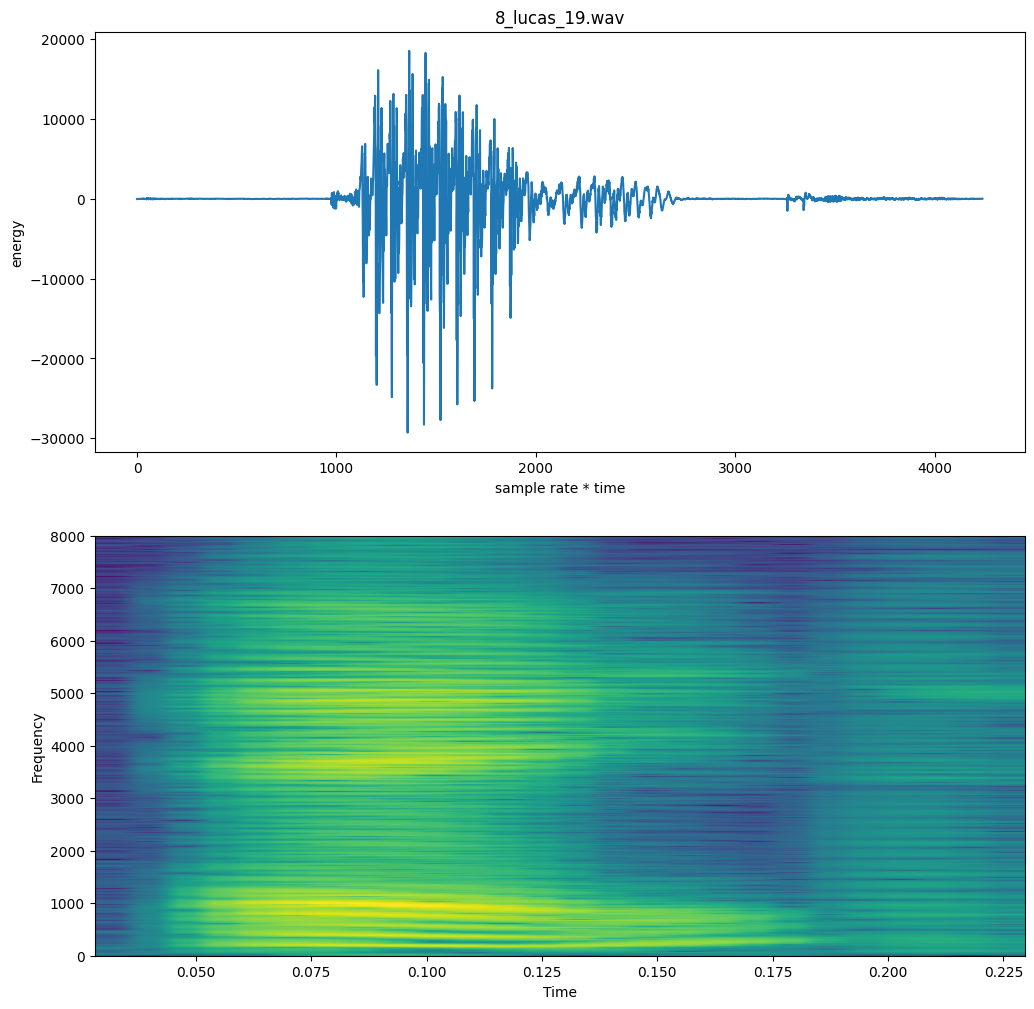

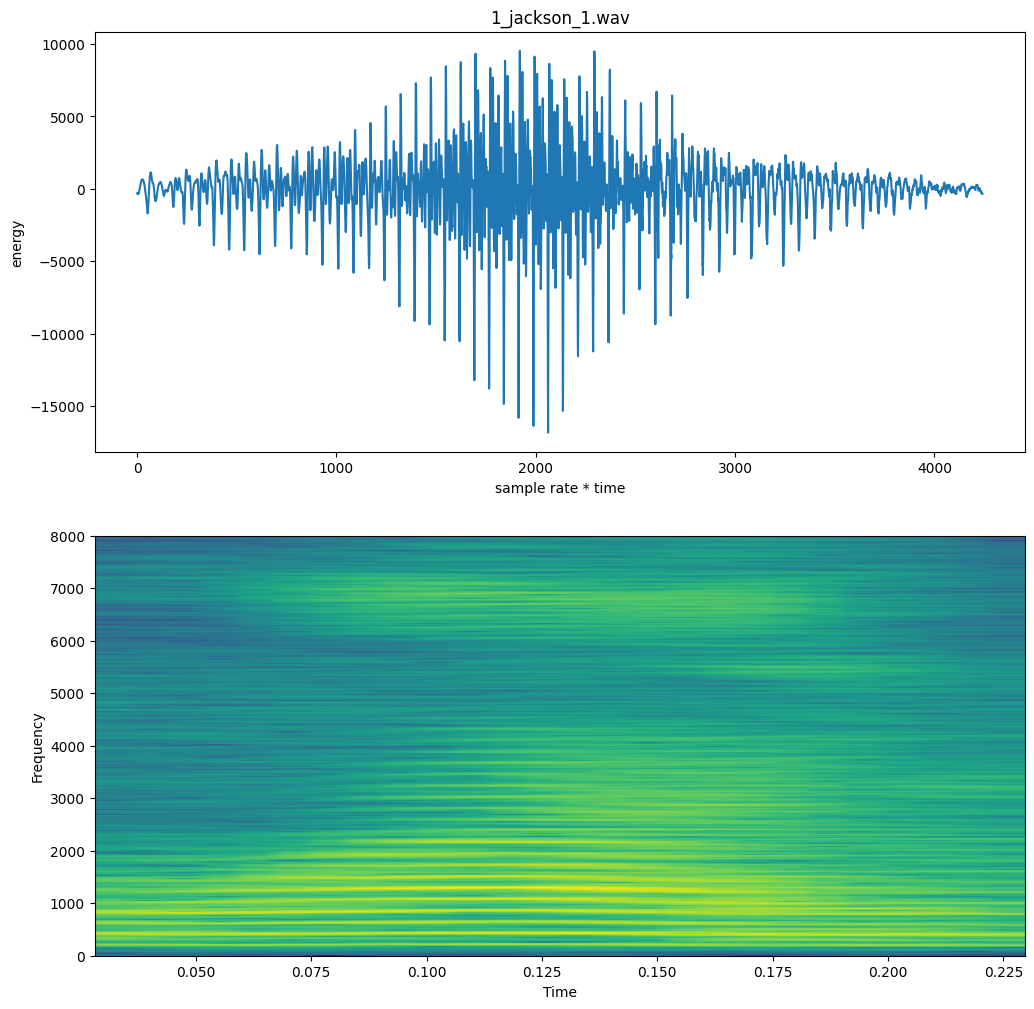

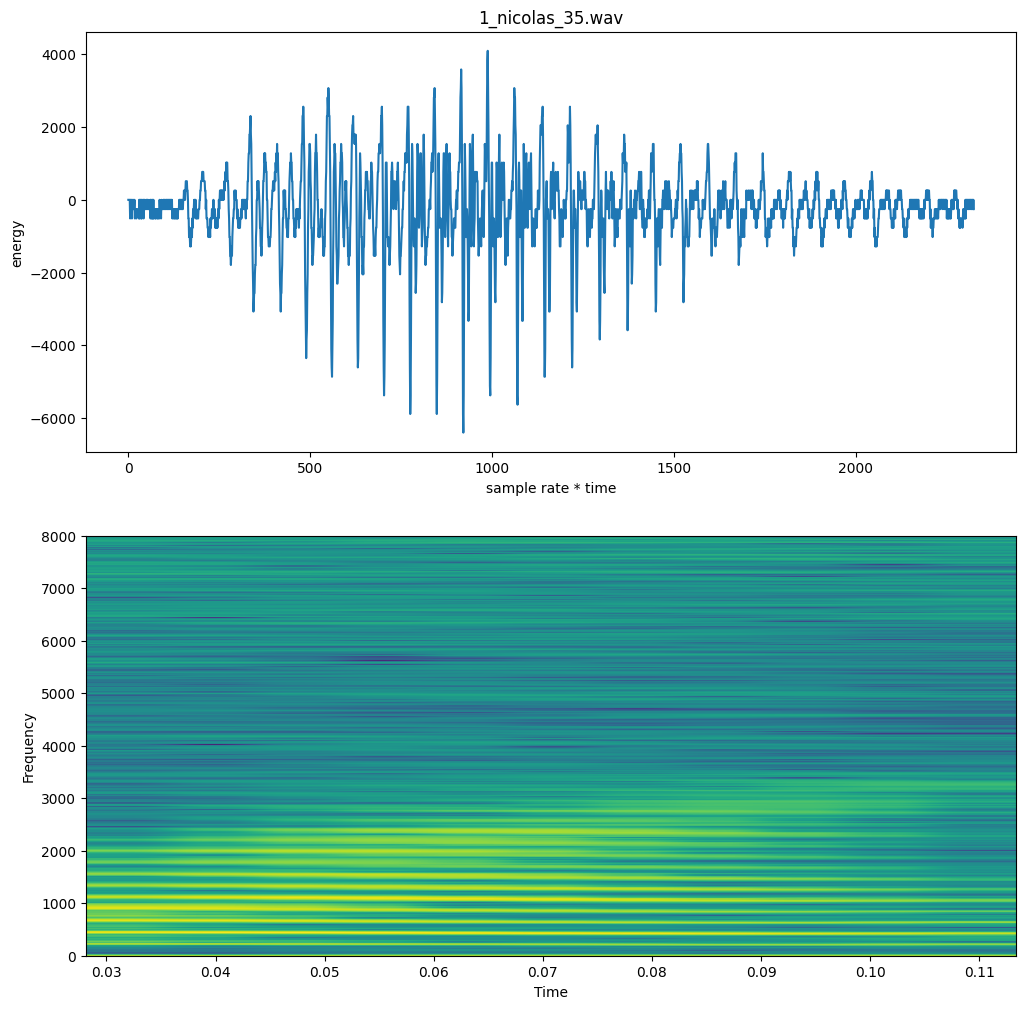

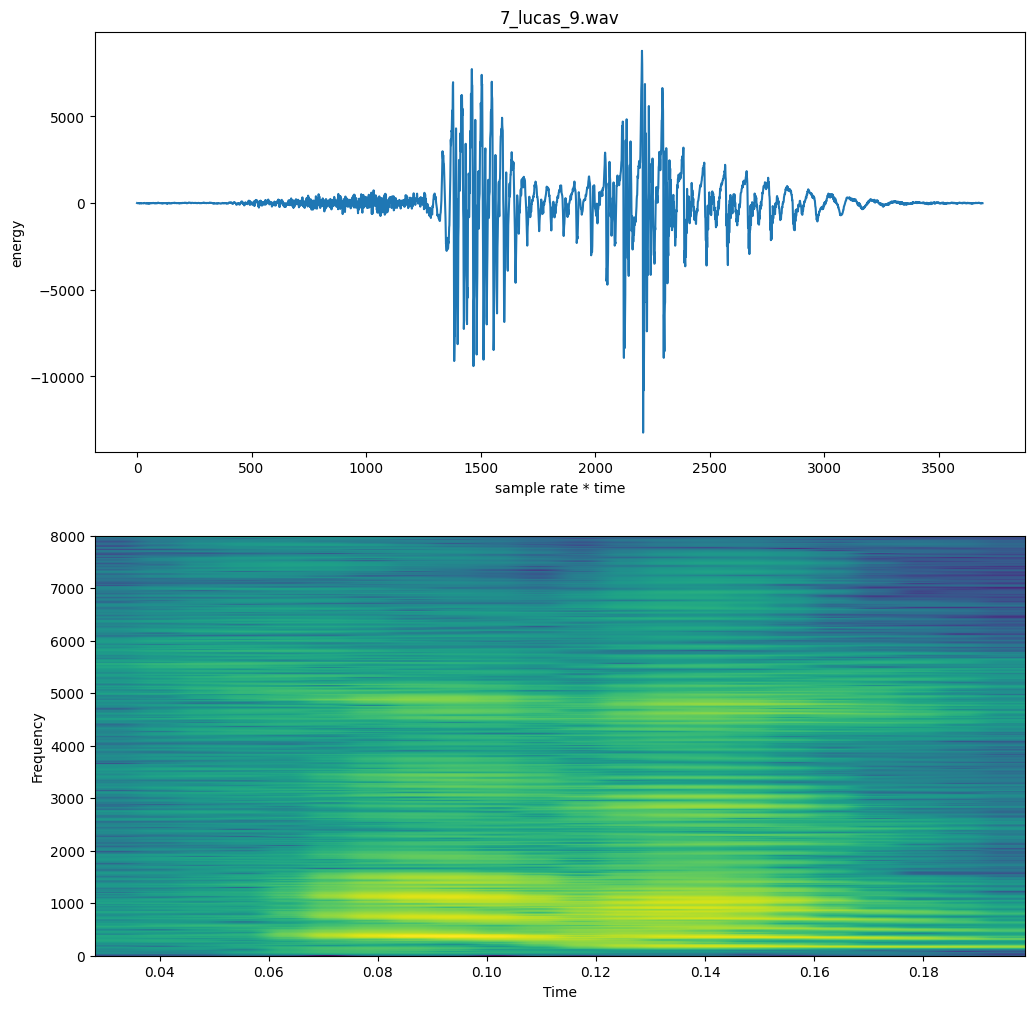

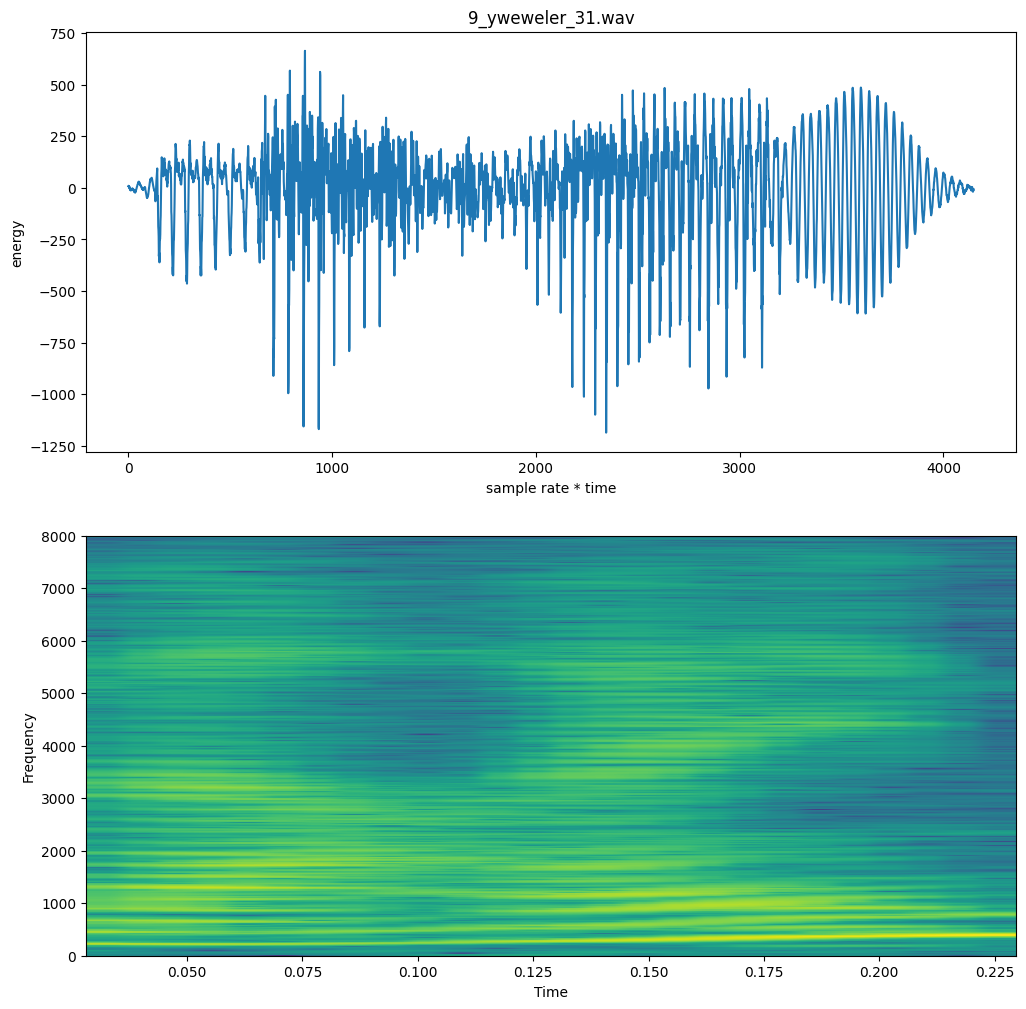

In [9]:
for i in range(5):
    signal_wave = wave.open(os.path.join(input_dir, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

KeyboardInterrupt: 

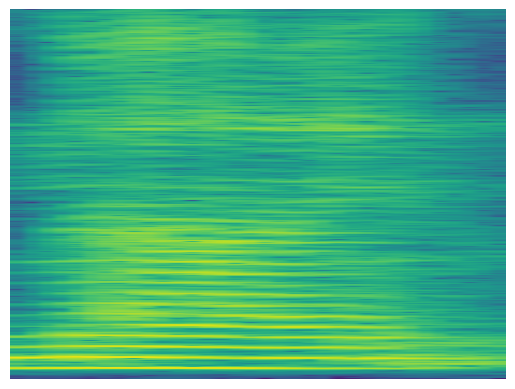

In [10]:
SIZE = 256
BATCH_SIZE = 32
channels = 3
kernel = 4
stride = 1
pool = 2
for filename in os.listdir(input_dir):
    if "wav" in filename:
        file_path = os.path.join(input_dir, filename)
        target_dir = f'class_{filename[0]}'
        dist_dir = os.path.join(output_dir, target_dir)
        file_dist_path = os.path.join(dist_dir, filename)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            frame_rate, data = wav.read(file_path)
            signal_wave = wave.open(file_path)
            sig = np.frombuffer(signal_wave.readframes(frame_rate), dtype=np.int16)
            fig = plt.figure()
            plt.specgram(sig, NFFT=1024, Fs=frame_rate, noverlap=900)
            plt.axis('off')
            fig.savefig(f'{file_dist_path}.png', dpi=fig.dpi)
            plt.close()

In [ ]:
target_dir

'class_3'

In [ ]:
dist_dir

'direct/class_3'

In [ ]:
file_dist_path

'direct/class_3/3_theo_11.wav'

In [ ]:
file_path

'/content/free-spoken-digit-dataset-master/recordings/3_theo_11.wav'

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="training",
                                             seed=0);

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="validation",
                                             seed=0);

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


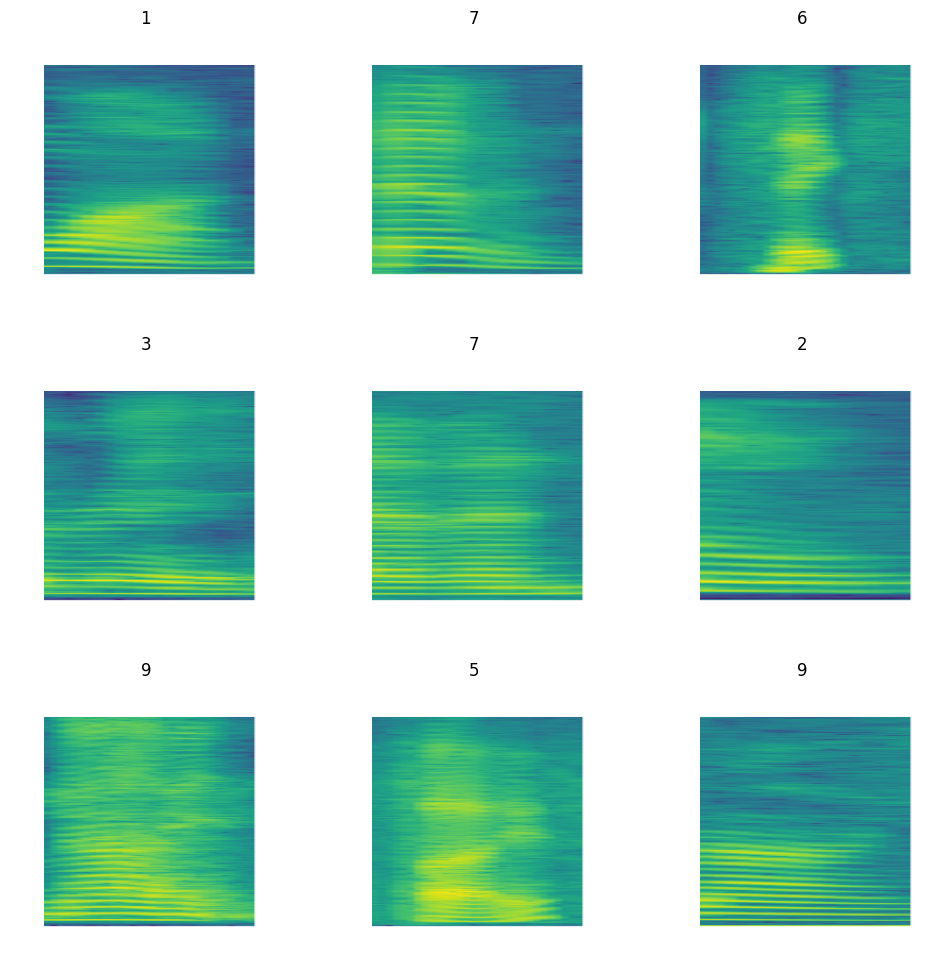

In [ ]:
plt.figure(figsize=(12, 12));
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1);
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(int(labels[i]));
        plt.axis("off");
plt.show();

In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(SIZE, SIZE, channels)),
    layers.Conv2D(16, kernel, stride, activation='relu'),
    layers.MaxPool2D(pool),
    layers.Conv2D(32, kernel, stride, activation='relu'),
    layers.MaxPool2D(pool),
    layers.Conv2D(64, kernel, stride, activation='relu'),
    layers.MaxPool2D(pool),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 253, 253, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        3

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
    train_ds, epochs=epochs, callbacks=model_checkpoint_callback, validation_data=val_ds,
);

Epoch 1/15
75/75 [==============================] - 34s 97ms/step - loss: 1.1928 - accuracy: 0.5908 - val_loss: 0.7006 - val_accuracy: 0.7417
Epoch 2/15
75/75 [==============================] - 3s 45ms/step - loss: 0.3391 - accuracy: 0.8946 - val_loss: 0.2710 - val_accuracy: 0.9133
Epoch 3/15
75/75 [==============================] - 3s 43ms/step - loss: 0.1638 - accuracy: 0.9483 - val_loss: 0.2580 - val_accuracy: 0.9367
Epoch 4/15
75/75 [==============================] - 3s 41ms/step - loss: 0.0990 - accuracy: 0.9700 - val_loss: 0.2411 - val_accuracy: 0.9267
Epoch 5/15
75/75 [==============================] - 3s 43ms/step - loss: 0.1052 - accuracy: 0.9646 - val_loss: 0.2020 - val_accuracy: 0.9400
Epoch 6/15
75/75 [==============================] - 3s 43ms/step - loss: 0.0516 - accuracy: 0.9854 - val_loss: 0.1610 - val_accuracy: 0.9567
Epoch 7/15
75/75 [==============================] - 3s 43ms/step - loss: 0.0519 - accuracy: 0.9833 - val_loss: 0.1420 - val_accuracy: 0.9650
Epoch 8/15
7

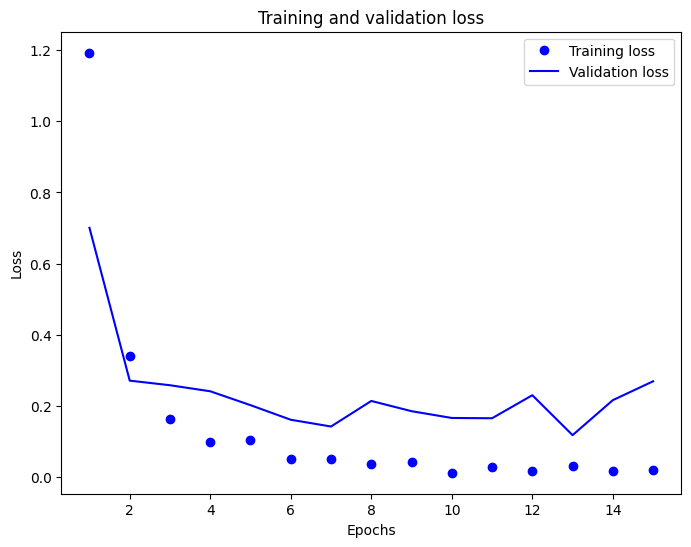

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

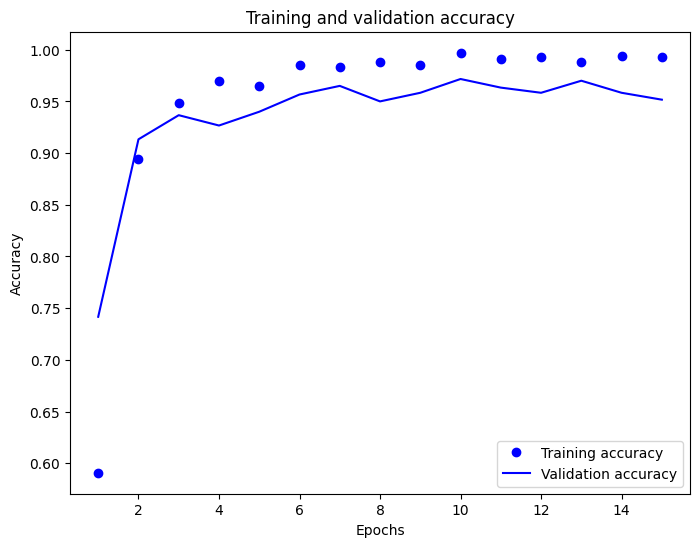

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **LSTM**

In [11]:
import librosa,librosa.display
from tqdm.notebook import tqdm

In [17]:
path='/content/free-spoken-digit-dataset-master/recordings/0_george_0.wav'
dir_path='/content/free-spoken-digit-dataset-master/recordings/'

In [18]:
raw_data,framerate=librosa.load(path)
raw_data,framerate

(array([-0.04229989, -0.04891741, -0.0376581 , ..., -0.00187707,
         0.00271878,  0.00249752], dtype=float32),
 22050)

In [27]:
import librosa,librosa.display
from tqdm.notebook import tqdm

path = '/content/free-spoken-digit-dataset-master/recordings/0_george_0.wav'
dir_path = '/content/free-spoken-digit-dataset-master/recordings/'

data = pd.DataFrame(columns=['raw_data', 'duration', 'digit'])

for i in tqdm(os.listdir(dir_path)):
    try:
        raw_data, frame_rate = librosa.load(dir_path + i)
        duration = librosa.get_duration(y=raw_data, sr=frame_rate)
        data.loc[len(data.index)] = [raw_data, duration, i.split('_')[0]]
    except FileNotFoundError:
        print(f"File not found: {dir_path + i}")
        continue

  0%|          | 0/3000 [00:00<?, ?it/s]

In [28]:
raw_data

array([ 9.97712137e-04, -8.25753668e-05, -1.45795196e-03, ...,
       -1.05724044e-04, -2.56077910e-04,  0.00000000e+00], dtype=float32)

In [29]:
frame_rate

22050

In [30]:
duration

0.22802721088435374

In [31]:
data.head()

,raw_data,duration,digit
0,"[-0.0004978992, -0.0004938762, -0.00023762758,...",0.530159,8
1,"[-0.008700029, -0.011038408, -0.010228105, -0....",0.530295,1
2,"[0.0004321201, -0.00026136916, -0.0008621653, ...",0.290658,1
3,"[5.7250916e-05, 9.932446e-06, -9.0659676e-05, ...",0.461633,7
4,"[0.00020454016, 0.0002725197, 0.00030081213, 0...",0.518776,9


In [32]:
X_train, X_test, y_train, y_test = train_test_split(data[['raw_data','duration']],data['digit'], test_size=0.3, random_state=45)

In [33]:
max_length=20366
X_train=tf.keras.preprocessing.sequence.pad_sequences(X_train['raw_data'],maxlen=max_length, dtype='float32')
X_test=tf.keras.preprocessing.sequence.pad_sequences(X_test['raw_data'],maxlen=max_length, dtype='float32')

In [34]:
X_train.shape

(2100, 20366)

In [35]:
def convert_to_spectrogram(raw_data):
    spect = librosa.feature.melspectrogram(y=raw_data, n_mels=64)
    mel_spect = librosa.power_to_db(S=spect, ref=np.max)
    return mel_spect

In [36]:
X_train_spectrogram=np.array([convert_to_spectrogram(np.array([float(i) for i in X_train[k] ])) for k in range(len(X_train)) ])
X_test_spectrogram=np.array([convert_to_spectrogram(np.array([float(i) for i in X_test[k] ])) for k in range(len(X_test)) ])
X_train_spectrogram.shape

(2100, 64, 40)

In [37]:
input_layer=Input(shape=(64,40), dtype=np.float32,name='input_layer')
lstm=LSTM(500,name='lstm_layer',return_sequences=True)(input_layer)
d1=Dense(120,activation='relu',name='dense1')(tf.math.reduce_mean(lstm, 2))
d2=Dense(60,activation='relu',name='dense2')(d1)
d3=Dense(60,activation='softmax',name='dense3')(d2)
model = Model(inputs=input_layer, outputs=d3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 40)]          0         
                                                                 
 lstm_layer (LSTM)           (None, 64, 500)           1082000   
                                                                 
 tf.math.reduce_mean (TFOpL  (None, 64)                0         
 ambda)                                                          
                                                                 
 dense1 (Dense)              (None, 120)               7800      
                                                                 
 dense2 (Dense)              (None, 60)                7260      
                                                                 
 dense3 (Dense)              (None, 60)                3660      
                                                             

In [38]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [39]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])

In [41]:
lstm_h=model.fit(X_train_spectrogram,y_train.astype('int')\
           ,validation_data=(X_test_spectrogram,y_test.astype('int'))\
           ,batch_size=32,epochs=15)

Epoch 1/15
66/66 [==============================] - 6s 24ms/step - loss: 2.8600 - accuracy: 0.0933 - val_loss: 2.3541 - val_accuracy: 0.1000
Epoch 2/15
66/66 [==============================] - 1s 13ms/step - loss: 2.3415 - accuracy: 0.1048 - val_loss: 2.3480 - val_accuracy: 0.0844
Epoch 3/15
66/66 [==============================] - 1s 13ms/step - loss: 2.3219 - accuracy: 0.0919 - val_loss: 2.3303 - val_accuracy: 0.0844
Epoch 4/15
66/66 [==============================] - 1s 18ms/step - loss: 2.3273 - accuracy: 0.0962 - val_loss: 2.3180 - val_accuracy: 0.0922
Epoch 5/15
66/66 [==============================] - 1s 21ms/step - loss: 2.3212 - accuracy: 0.1038 - val_loss: 2.3286 - val_accuracy: 0.0922
Epoch 6/15
66/66 [==============================] - 2s 30ms/step - loss: 2.3225 - accuracy: 0.1005 - val_loss: 2.3177 - val_accuracy: 0.1078
Epoch 7/15
66/66 [==============================] - 2s 31ms/step - loss: 2.3194 - accuracy: 0.1033 - val_loss: 2.3082 - val_accuracy: 0.1000
Epoch 8/15
66

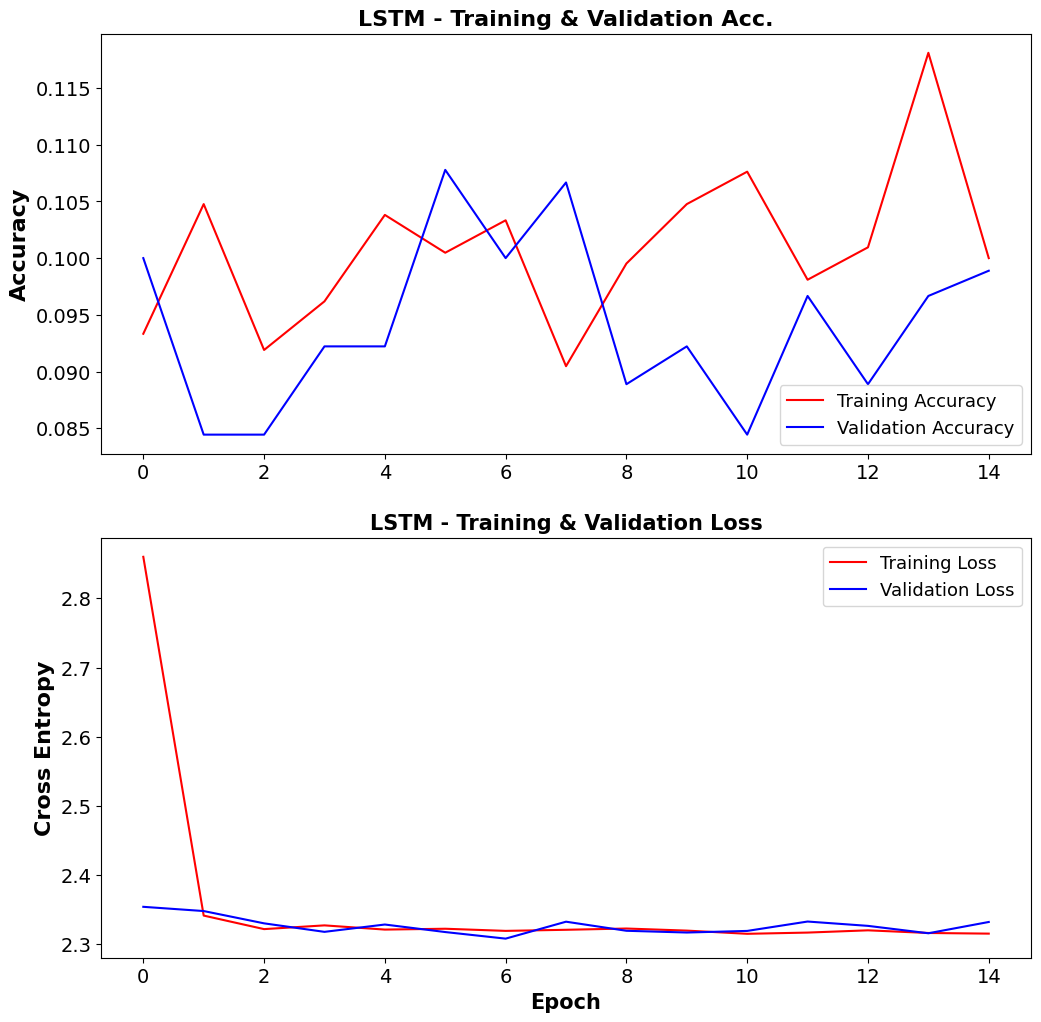

In [42]:
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']

loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()
